## 🔧 Setup and Imports

Import all three models and utilities.

In [18]:
# Core libraries
import sys
import os
import json
import numpy as np
from pathlib import Path
from typing import Dict, Tuple, List
import time

# MLX for deep learning
import mlx.core as mx
import mlx.nn as nn
import mlx.optimizers as optim

# Import all utilities from consolidated module
from mlx_nlp_utils import (
    # Intent classification
    IntentLSTM,
    predict_intent,
    # Sentiment analysis
    SentimentLSTM,
    predict_sentiment,
    # Text generation
    TextLSTM,
    create_char_vocab,
    text_to_sequences,
    generate_text,
    # Shared utilities
    create_vocabulary,
    preprocess_text,
    texts_to_sequences,
    pad_sequences,
    train_model,
    # Hardware check
    print_device_info
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✅ All libraries imported successfully!")
print("🤖 Complete NLP Pipeline is ready!")
print(f"🖥️  MLX version: {mx.__version__}")
print(f"🐍 Python version: {sys.version.split()[0]}")

# Check hardware acceleration
print_device_info()

ImportError: cannot import name 'print_device_info' from 'mlx_nlp_utils' (/Users/mark/git/apple-mlx-tutorial/notebooks/mlx_nlp_utils.py)

## 📚 Step 1: Load All Training Data

Load data for all three models.

In [ ]:
# Check if data exists
data_dirs = {
    'intent': '../data/intent_samples',
    'sentiment': '../data/sentiment_samples',
    'text_gen': '../data/text_gen_samples'
}

all_exist = all(os.path.exists(d) for d in data_dirs.values())

if not all_exist:
    print("⚠️ Sample data not found. Run this first:")
    print("   python ../scripts/download_datasets.py --samples")
else:
    print("✅ All data directories found!")
    print(f"\n📊 Data Locations:")
    for name, path in data_dirs.items():
        print(f"   {name.capitalize()}: {path}")

✅ All data directories found!

📊 Data Locations:
   Intent: ../data/intent_samples
   Sentiment: ../data/sentiment_samples
   Text_gen: ../data/text_gen_samples


### 📥 Load Intent Data

In [ ]:
# Load intent data from JSON
with open(f"{data_dirs['intent']}/data.json", 'r') as f:
    intent_data = json.load(f)

intent_texts = intent_data['texts']
intent_labels_str = intent_data['labels']
intent_names = ['greeting', 'question', 'command']

# Convert string labels to integers
intent2idx = {name: idx for idx, name in enumerate(intent_names)}
intent_labels = [intent2idx[label] for label in intent_labels_str]

print(f"📊 Intent Data:")
print(f"   Samples: {len(intent_texts)}")
print(f"   Classes: {intent_names}")
print(f"   Example: '{intent_texts[0]}' → {intent_names[intent_labels[0]]}")

📊 Intent Data:
   Samples: 9
   Classes: ['greeting', 'question', 'command']
   Example: 'hello there' → greeting


### 📥 Load Sentiment Data

In [ ]:
# Load sentiment data from JSON
with open(f"{data_dirs['sentiment']}/data.json", 'r') as f:
    sentiment_data = json.load(f)

sentiment_texts = sentiment_data['texts']
sentiment_labels_str = sentiment_data['labels']
sentiment_names = ['negative', 'neutral', 'positive']

# Convert string labels to integers
sentiment2idx = {'negative': 0, 'neutral': 1, 'positive': 2}
sentiment_labels = [sentiment2idx[label] for label in sentiment_labels_str]

print(f"📊 Sentiment Data:")
print(f"   Samples: {len(sentiment_texts)}")
print(f"   Classes: {sentiment_names}")
print(f"   Example: '{sentiment_texts[0]}' → {sentiment_names[sentiment_labels[0]]}")

📊 Sentiment Data:
   Samples: 8
   Classes: ['negative', 'neutral', 'positive']
   Example: 'This movie was absolutely fantastic!' → positive


### 📥 Load Text Generation Corpus

In [ ]:
# Load corpus
with open(f"{data_dirs['text_gen']}/corpus.txt", 'r', encoding='utf-8') as f:
    corpus = f.read()

print(f"📊 Text Generation Data:")
print(f"   Characters: {len(corpus):,}")
print(f"   Words: {len(corpus.split()):,}")
print(f"   Preview: '{corpus[:100]}...'")

📊 Text Generation Data:
   Characters: 366
   Words: 52
   Preview: 'The quick brown fox jumps over the lazy dog.
Machine learning is a subset of artificial intelligence...'


## 🏗️ Step 2: Build and Train All Models

Create unified training pipeline.

In [ ]:
print("🏗️ Building All Models...\n")
print("=" * 70)

# Store model artifacts
models = {}
vocabs = {}
configs = {}

print("\n⏳ This will take 3-4 minutes total...")

🏗️ Building All Models...


⏳ This will take 3-4 minutes total...


### 🎯 Train Intent Classifier

In [ ]:
print("\n1️⃣  Training Intent Classifier...")
start_time = time.time()

# Preprocess
intent_vocab, intent_word_to_idx = create_vocabulary(intent_texts)
intent_sequences = texts_to_sequences(intent_texts, intent_word_to_idx)
intent_max_len = max(len(seq) for seq in intent_sequences)
intent_X_train = mx.array(pad_sequences(intent_sequences, intent_max_len))
intent_y_train = mx.array(intent_labels)

# Train
intent_model = IntentLSTM(
    vocab_size=len(intent_vocab),
    embedding_dim=32,
    hidden_size=64,
    output_size=3
)

import mlx.core as mx
import mlx.nn as nn
import mlx.optimizers as optim

def loss_fn(model, X, y):
    logits = model(X)
    return mx.mean(nn.losses.cross_entropy(logits, y))

optimizer = optim.SGD(learning_rate=0.01)
loss_and_grad_fn = nn.value_and_grad(intent_model, loss_fn)

for epoch in range(50):
    loss, grads = loss_and_grad_fn(intent_model, intent_X_train, intent_y_train)
    optimizer.update(intent_model, grads)
    
    # Force evaluation (Lazy Evaluation pattern)
    # MLX builds a computation graph but doesn't run it until needed.
    # mx.eval() forces execution to update parameters in memory.
    mx.eval(intent_model.parameters(), optimizer.state)

# Store
models['intent'] = intent_model
vocabs['intent'] = (intent_vocab, intent_word_to_idx)
configs['intent'] = {
    'max_len': intent_max_len,
    'classes': intent_names
}

elapsed = time.time() - start_time
print(f"   ✅ Intent classifier trained in {elapsed:.1f}s")
print(f"   Vocabulary: {len(intent_vocab)} words")


1️⃣  Training Intent Classifier...
   ✅ Intent classifier trained in 0.5s
   Vocabulary: 28 words
   ✅ Intent classifier trained in 0.5s
   Vocabulary: 28 words


### 💭 Train Sentiment Analyzer

In [ ]:
print("\n2️⃣  Training Sentiment Analyzer...")
start_time = time.time()

# Preprocess
sentiment_vocab, sentiment_word_to_idx = create_vocabulary(sentiment_texts)
sentiment_sequences = texts_to_sequences(sentiment_texts, sentiment_word_to_idx)
sentiment_max_len = max(len(seq) for seq in sentiment_sequences)
sentiment_X_train = mx.array(pad_sequences(sentiment_sequences, sentiment_max_len))
sentiment_y_train = mx.array(sentiment_labels)

# Train
sentiment_model = SentimentLSTM(
    vocab_size=len(sentiment_vocab),
    embedding_dim=64,
    hidden_size=128,
    output_size=3
)

optimizer = optim.Adam(learning_rate=0.001)
loss_and_grad_fn = nn.value_and_grad(sentiment_model, loss_fn)

for epoch in range(100):
    loss, grads = loss_and_grad_fn(sentiment_model, sentiment_X_train, sentiment_y_train)
    optimizer.update(sentiment_model, grads)
    mx.eval(sentiment_model.parameters(), optimizer.state)

# Store
models['sentiment'] = sentiment_model
vocabs['sentiment'] = (sentiment_vocab, sentiment_word_to_idx)
configs['sentiment'] = {
    'max_len': sentiment_max_len,
    'classes': sentiment_names
}

elapsed = time.time() - start_time
print(f"   ✅ Sentiment analyzer trained in {elapsed:.1f}s")
print(f"   Vocabulary: {len(sentiment_vocab)} words")


2️⃣  Training Sentiment Analyzer...
   ✅ Sentiment analyzer trained in 0.3s
   Vocabulary: 35 words
   ✅ Sentiment analyzer trained in 0.3s
   Vocabulary: 35 words


### ✨ Train Text Generator

In [ ]:
print("\n3️⃣  Training Text Generator...")
start_time = time.time()

# Preprocess
gen_vocab, gen_char_to_idx, gen_idx_to_char = create_char_vocab(corpus)
gen_seq_length = 5
gen_X, gen_y = text_to_sequences(corpus, gen_char_to_idx, gen_seq_length)

# Train
gen_model = TextLSTM(
    vocab_size=len(gen_vocab),
    embedding_dim=128,
    hidden_size=256
)

def gen_loss_fn(model, X, y):
    logits = model(mx.array(X))
    # Take only the last position's logits for prediction
    logits_last = logits[:, -1, :]
    return mx.mean(nn.losses.cross_entropy(logits_last, mx.array(y)))

optimizer = optim.Adam(learning_rate=0.001)
loss_and_grad_fn = nn.value_and_grad(gen_model, gen_loss_fn)

for epoch in range(200):
    loss, grads = loss_and_grad_fn(gen_model, gen_X, gen_y)
    optimizer.update(gen_model, grads)
    mx.eval(gen_model.parameters(), optimizer.state)

# Store
models['generator'] = gen_model
vocabs['generator'] = gen_vocab
configs['generator'] = {
    'char_to_idx': gen_char_to_idx,
    'idx_to_char': gen_idx_to_char,
    'seq_length': gen_seq_length
}

elapsed = time.time() - start_time
print(f"   ✅ Text generator trained in {elapsed:.1f}s")
print(f"   Vocabulary: {len(gen_vocab)} characters")

print("\n" + "=" * 70)
print("✅ All models trained successfully!")


3️⃣  Training Text Generator...
   ✅ Text generator trained in 1.4s
   Vocabulary: 38 characters

✅ All models trained successfully!
   ✅ Text generator trained in 1.4s
   Vocabulary: 38 characters

✅ All models trained successfully!


## 🤖 Step 3: Build Chatbot Pipeline

Combine all models into a unified chatbot system.

### 🏗️ System Architecture: The Ensemble Pattern

We are building a **Multi-Model Pipeline** (or Ensemble). Instead of one giant "General AI" model, we use specialized experts:

1.  **Router (Intent Classifier)**: Determines *what* to do.
2.  **Analyst (Sentiment Analyzer)**: Determines *how* to modify the tone.
3.  **Worker (Text Generator)**: Performs the creative writing task if no template exists.

**✅ Pros:**
*   **Modularity**: You can retrain the Intent Classifier without breaking the Sentiment Analyzer.
*   **Debuggability**: If the bot is rude, you check the Sentiment model. If it answers the wrong question, you check the Intent model.
*   **Performance**: Specialized small models are often faster and more accurate for their specific task than one massive model.

**❌ Cons:**
*   **Latency**: We must run inference on 3 different models for every user message.
*   **Complexity**: Managing multiple vocabularies and configurations.

### 🔮 Future Considerations: The LLM Shift
In modern production systems (post-2023), this pipeline is often replaced or augmented by a single Large Language Model (LLM) like GPT-4 or Llama-3, which can handle intent, sentiment, and generation simultaneously. However, the pipeline approach remains valid for:
*   **Low-latency edge devices** (like IoT).
*   **Strict deterministic control** (banking/medical apps).
*   **Cost reduction** (running small LSTMs is cheaper than LLMs).

In [ ]:
class MLXChatbot:
    """Complete chatbot using all three models."""
    
    def __init__(self, models, vocabs, configs):
        self.models = models
        self.vocabs = vocabs
        self.configs = configs
        
        # Confidence thresholds
        self.intent_threshold = 0.6
        self.sentiment_threshold = 0.5
        
        # Response templates
        self.templates = {
            'greeting': [
                "Hello! How can I help you today?",
                "Hi there! What can I do for you?",
                "Hey! Nice to meet you!"
            ],
            'question': [
                "That's an interesting question! Let me think...",
                "Great question! Here's what I think:",
                "I'd be happy to help with that."
            ],
            'command': [
                "I'll get right on that!",
                "Sure, let me help you with that.",
                "Consider it done!"
            ]
        }
    
    def process(self, user_input: str) -> Dict:
        """Process user input through complete pipeline."""
        
        # 1. Detect intent
        intent, intent_conf = predict_intent(
            self.models['intent'],
            user_input,
            self.vocabs['intent'][1],  # Use word_to_idx (index 1), not vocab set
            self.configs['intent']['classes'],
            self.configs['intent']['max_len']
        )
        
        # 2. Analyze sentiment
        sentiment, sentiment_conf = predict_sentiment(
            self.models['sentiment'],
            user_input,
            self.vocabs['sentiment'][1],  # Use word_to_idx (index 1), not vocab set
            self.configs['sentiment']['classes'],
            self.configs['sentiment']['max_len']
        )
        
        # 3. Generate response based on intent
        if intent_conf > self.intent_threshold:
            # High confidence: use template
            import random
            base_response = random.choice(self.templates[intent])
        else:
            # Low confidence: generate text
            seed = user_input[:5] if len(user_input) >= 5 else "I thi"
            base_response = generate_text(
                self.models['generator'],
                seed,
                self.configs['generator']['char_to_idx'],
                self.configs['generator']['idx_to_char'],
                length=80,
                temperature=0.8
            )
        
        # 4. Adjust response based on sentiment
        if sentiment == 'negative' and sentiment_conf > self.sentiment_threshold:
            response = f"I sense you might be frustrated. {base_response}"
        elif sentiment == 'positive' and sentiment_conf > self.sentiment_threshold:
            response = f"I'm glad you're in a good mood! {base_response}"
        else:
            response = base_response
        
        return {
            'user_input': user_input,
            'intent': intent,
            'intent_confidence': intent_conf,
            'sentiment': sentiment,
            'sentiment_confidence': sentiment_conf,
            'response': response
        }

# Create chatbot
chatbot = MLXChatbot(models, vocabs, configs)
print("🤖 Chatbot initialized and ready!")
print(f"\n⚙️ Configuration:")
print(f"   Intent threshold: {chatbot.intent_threshold}")
print(f"   Sentiment threshold: {chatbot.sentiment_threshold}")

🤖 Chatbot initialized and ready!

⚙️ Configuration:
   Intent threshold: 0.6
   Sentiment threshold: 0.5


## 💬 Step 4: Interactive Chat Session

Let's test our chatbot!

In [ ]:
# Test inputs
test_inputs = [
    "Hello there!",
    "What is machine learning?",
    "Show me the weather",
    "This is amazing! I love it!",
    "I'm having a terrible day",
    "Can you help me with something?"
]

print("💬 Chatbot Conversation\n")
print("=" * 80)

results = []
for user_input in test_inputs:
    result = chatbot.process(user_input)
    results.append(result)
    
    print(f"\n👤 User: {result['user_input']}")
    print(f"\n🔍 Analysis:")
    print(f"   Intent: {result['intent']} (confidence: {result['intent_confidence']:.1%})")
    print(f"   Sentiment: {result['sentiment']} (confidence: {result['sentiment_confidence']:.1%})")
    print(f"\n🤖 Bot: {result['response']}")
    print("-" * 80)

💬 Chatbot Conversation


👤 User: Hello there!

🔍 Analysis:
   Intent: greeting (confidence: 35.5%)
   Sentiment: negative (confidence: 100.0%)

🤖 Bot: I sense you might be frustrated. Hellonga..
MLX is Apple's framework for ML acceleration.
MLX is Apple's framework for
--------------------------------------------------------------------------------

👤 User: What is machine learning?

🔍 Analysis:
   Intent: greeting (confidence: 35.1%)
   Sentiment: positive (confidence: 100.0%)

🤖 Bot: I'm glad you're in a good mood! What lemawichhe l amewurk for machine learning is a subset of artificial intelligence
--------------------------------------------------------------------------------

👤 User: Show me the weather

🔍 Analysis:
   Intent: greeting (confidence: 35.1%)
   Sentiment: positive (confidence: 100.0%)

🤖 Bot: I'm glad you're in a good mood! Show ss asdungea liang lagers.
Apple's framework for machine learning is a subset of 
----------------------------------------------------------

### 📊 Visualize Chatbot Performance

Analyze confidence scores across the conversation.

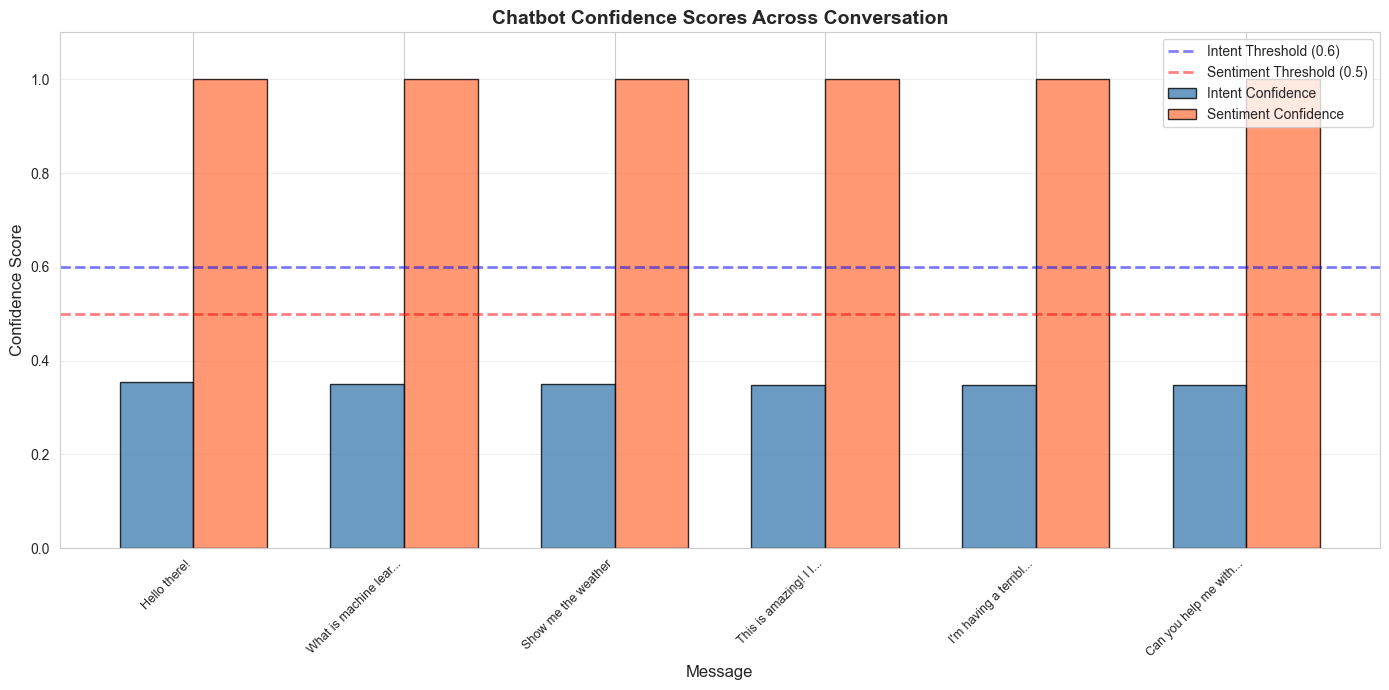


📊 Average Confidence Scores:
   Intent: 35.0%
   Sentiment: 100.0%


In [ ]:
# Extract data for visualization
messages = [r['user_input'][:20] + '...' if len(r['user_input']) > 20 else r['user_input'] 
           for r in results]
intent_confs = [r['intent_confidence'] for r in results]
sentiment_confs = [r['sentiment_confidence'] for r in results]

# Create grouped bar chart
fig, ax = plt.subplots(figsize=(14, 7))

x = np.arange(len(messages))
width = 0.35

bars1 = ax.bar(x - width/2, intent_confs, width, label='Intent Confidence', 
              color='steelblue', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x + width/2, sentiment_confs, width, label='Sentiment Confidence',
              color='coral', alpha=0.8, edgecolor='black')

# Add threshold lines
ax.axhline(y=chatbot.intent_threshold, color='blue', linestyle='--', 
          linewidth=2, alpha=0.5, label=f'Intent Threshold ({chatbot.intent_threshold})')
ax.axhline(y=chatbot.sentiment_threshold, color='red', linestyle='--',
          linewidth=2, alpha=0.5, label=f'Sentiment Threshold ({chatbot.sentiment_threshold})')

ax.set_xlabel('Message', fontsize=12)
ax.set_ylabel('Confidence Score', fontsize=12)
ax.set_title('Chatbot Confidence Scores Across Conversation', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(messages, rotation=45, ha='right', fontsize=9)
ax.set_ylim([0, 1.1])
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Average Confidence Scores:")
print(f"   Intent: {np.mean(intent_confs):.1%}")
print(f"   Sentiment: {np.mean(sentiment_confs):.1%}")

### 🎯 Intent Distribution Analysis

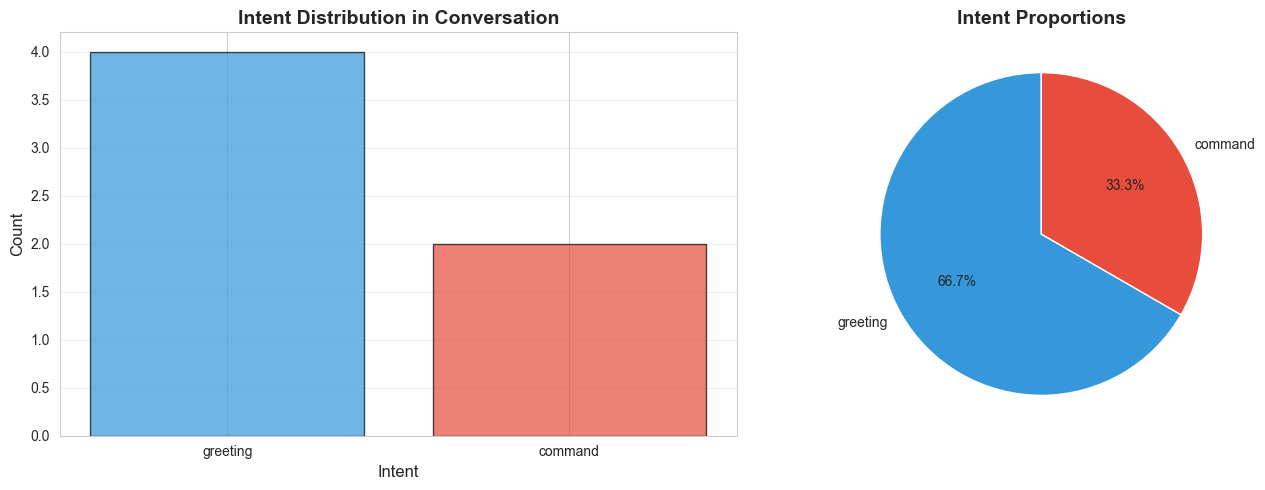

In [ ]:
# Count intents
from collections import Counter
intent_counts = Counter(r['intent'] for r in results)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
colors = ['#3498db', '#e74c3c', '#2ecc71']
ax1.bar(intent_counts.keys(), intent_counts.values(), color=colors, edgecolor='black', alpha=0.7)
ax1.set_title('Intent Distribution in Conversation', fontsize=14, fontweight='bold')
ax1.set_ylabel('Count', fontsize=12)
ax1.set_xlabel('Intent', fontsize=12)
ax1.grid(axis='y', alpha=0.3)

# Pie chart
ax2.pie(intent_counts.values(), labels=intent_counts.keys(), colors=colors,
       autopct='%1.1f%%', startangle=90)
ax2.set_title('Intent Proportions', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 🎨 Step 5: Custom Chat Interface

Try your own messages!

💬 Custom Chat


👤 You: Your message here...

🔍 Internal Analysis:
   Intent: greeting
   Intent Confidence: 35.2%
   Sentiment: positive
   Sentiment Confidence: 99.8%

🤖 Bot: I'm glad you're in a good mood! Your ne roick brown fox jumps over the lazy dog.
Machine learning uses neural languag



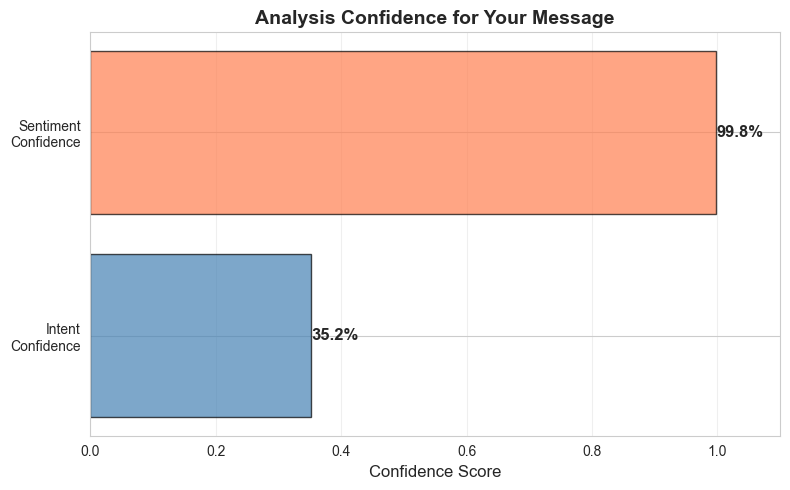

In [ ]:
# YOUR CUSTOM MESSAGE
custom_message = "Your message here..."

# Process
result = chatbot.process(custom_message)

print("💬 Custom Chat\n")
print("=" * 70)
print(f"\n👤 You: {result['user_input']}")
print(f"\n🔍 Internal Analysis:")
print(f"   Intent: {result['intent']}")
print(f"   Intent Confidence: {result['intent_confidence']:.1%}")
print(f"   Sentiment: {result['sentiment']}")
print(f"   Sentiment Confidence: {result['sentiment_confidence']:.1%}")
print(f"\n🤖 Bot: {result['response']}")
print("\n" + "=" * 70)

# Visualize this interaction
fig, ax = plt.subplots(figsize=(8, 5))

metrics = ['Intent\nConfidence', 'Sentiment\nConfidence']
values = [result['intent_confidence'], result['sentiment_confidence']]
colors_viz = ['steelblue', 'coral']

bars = ax.barh(metrics, values, color=colors_viz, edgecolor='black', alpha=0.7)

# Add value labels
for bar, val in zip(bars, values):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2.,
           f'{val:.1%}',
           ha='left', va='center', fontsize=12, fontweight='bold')

ax.set_xlim([0, 1.1])
ax.set_xlabel('Confidence Score', fontsize=12)
ax.set_title('Analysis Confidence for Your Message', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## 📈 Step 6: Performance Metrics

Analyze the complete pipeline performance.

In [ ]:
# Calculate metrics - MLX parameters are nested dicts of arrays
def count_params(model):
    """Count total parameters in an MLX model"""
    total = 0
    for layer_params in model.parameters().values():
        if isinstance(layer_params, dict):
            # Nested dict (e.g., LSTM)
            for param in layer_params.values():
                total += param.size
        else:
            # Direct array
            total += layer_params.size
    return total

intent_params = count_params(models['intent'])
sentiment_params = count_params(models['sentiment'])
generator_params = count_params(models['generator'])
total_params = intent_params + sentiment_params + generator_params

print("📊 Complete Pipeline Statistics\n")
print("=" * 70)
print(f"\n🧠 Model Complexity:")
print(f"   Total parameters: ~{total_params:,}")
print(f"   Intent model: {intent_params:,}")
print(f"   Sentiment model: {sentiment_params:,}")
print(f"   Generator model: {generator_params:,}")

print(f"\n📚 Vocabulary Sizes:")
print(f"   Intent: {len(vocabs['intent'][0])} words")  # Extract from tuple
print(f"   Sentiment: {len(vocabs['sentiment'][0])} words")  # Extract from tuple
print(f"   Generator: {len(vocabs['generator'])} characters")

print(f"\n⚙️ Configuration:")
print(f"   Intent max length: {configs['intent']['max_len']}")
print(f"   Sentiment max length: {configs['sentiment']['max_len']}")
print(f"   Generator sequence length: {configs['generator']['seq_length']}")

📊 Complete Pipeline Statistics


🧠 Model Complexity:
   Total parameters: ~536,236
   Intent model: 25,923
   Sentiment model: 101,443
   Generator model: 408,870

📚 Vocabulary Sizes:
   Intent: 28 words
   Sentiment: 35 words
   Generator: 38 characters

⚙️ Configuration:
   Intent max length: 5
   Sentiment max length: 6
   Generator sequence length: 5


### ⚡ Inference Speed Test

⚡ Speed Test (10 runs)


⏱️ Timing Results:
   Average: 31.4ms
   Std Dev: 2.1ms
   Min: 30.5ms
   Max: 37.5ms

💡 Throughput: ~31.9 messages/second

⏱️ Timing Results:
   Average: 31.4ms
   Std Dev: 2.1ms
   Min: 30.5ms
   Max: 37.5ms

💡 Throughput: ~31.9 messages/second


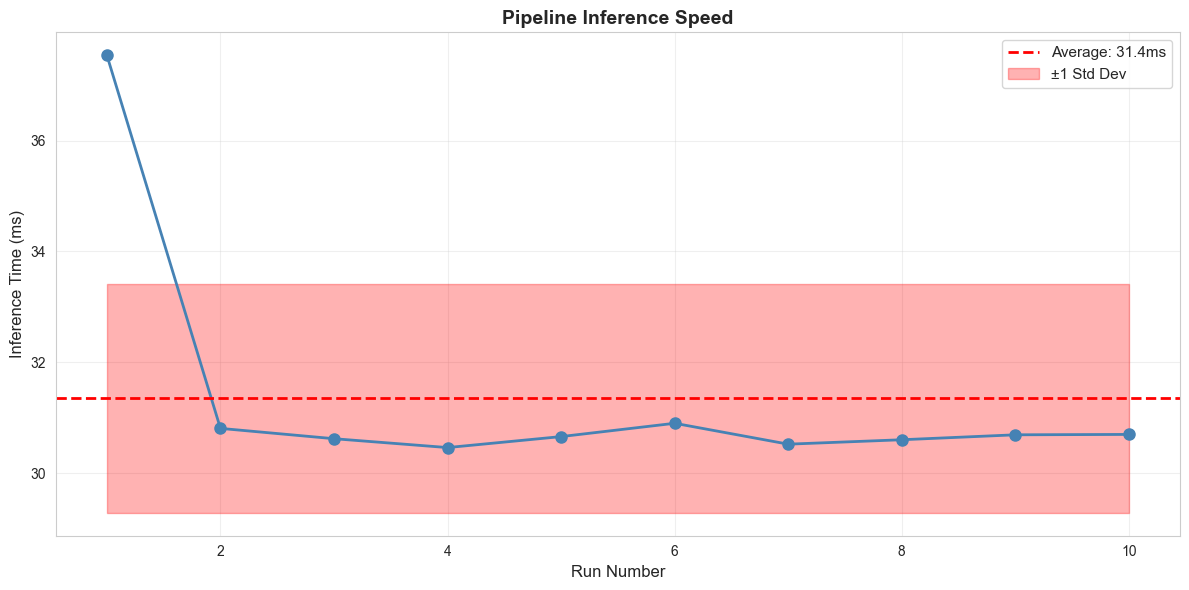

In [ ]:
# Test inference speed
test_message = "Hello! Can you help me with something?"
num_runs = 10

print(f"⚡ Speed Test ({num_runs} runs)\n")
print("=" * 70)

times = []
for i in range(num_runs):
    start = time.time()
    chatbot.process(test_message)
    elapsed = time.time() - start
    times.append(elapsed)

avg_time = np.mean(times)
std_time = np.std(times)

print(f"\n⏱️ Timing Results:")
print(f"   Average: {avg_time*1000:.1f}ms")
print(f"   Std Dev: {std_time*1000:.1f}ms")
print(f"   Min: {min(times)*1000:.1f}ms")
print(f"   Max: {max(times)*1000:.1f}ms")
print(f"\n💡 Throughput: ~{1/avg_time:.1f} messages/second")

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(range(1, num_runs+1), [t*1000 for t in times], 
       marker='o', linewidth=2, markersize=8, color='steelblue')
ax.axhline(y=avg_time*1000, color='red', linestyle='--', 
          linewidth=2, label=f'Average: {avg_time*1000:.1f}ms')
ax.fill_between(range(1, num_runs+1), 
               [(avg_time-std_time)*1000]*num_runs,
               [(avg_time+std_time)*1000]*num_runs,
               alpha=0.3, color='red', label=f'±1 Std Dev')

ax.set_xlabel('Run Number', fontsize=12)
ax.set_ylabel('Inference Time (ms)', fontsize=12)
ax.set_title('Pipeline Inference Speed', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 🚀 Step 7: Production Deployment Tips

Ready to deploy your chatbot? Here's what you need to know.

In [ ]:
print("🚀 Production Deployment Checklist\n")
print("=" * 70)
print("\n✅ Essential Steps:")
print("\n1️⃣  Model Optimization")
print("   - Quantize models to reduce size")
print("   - Batch inference for multiple users")
print("   - Cache embeddings for common inputs")
print("   - Use smaller vocabulary for faster lookup")

print("\n2️⃣  API Design")
print("   - RESTful endpoints with FastAPI/Flask")
print("   - WebSocket for real-time chat")
print("   - Rate limiting per user")
print("   - Input validation and sanitization")

print("\n3️⃣  Monitoring")
print("   - Log all predictions with confidence scores")
print("   - Track response times and errors")
print("   - Monitor model drift over time")
print("   - A/B test different model versions")

print("\n4️⃣  Scalability")
print("   - Containerize with Docker")
print("   - Load balancing for high traffic")
print("   - Database for conversation history")
print("   - CDN for static assets")

print("\n5️⃣  User Experience")
print("   - Fallback responses for low confidence")
print("   - Context-aware multi-turn conversations")
print("   - Personalization based on user history")
print("   - Graceful error handling")

print("\n💡 For complete production guide, see:")
print("   ../PRODUCTION_README.md")

🚀 Production Deployment Checklist


✅ Essential Steps:

1️⃣  Model Optimization
   - Quantize models to reduce size
   - Batch inference for multiple users
   - Cache embeddings for common inputs
   - Use smaller vocabulary for faster lookup

2️⃣  API Design
   - RESTful endpoints with FastAPI/Flask
   - WebSocket for real-time chat
   - Rate limiting per user
   - Input validation and sanitization

3️⃣  Monitoring
   - Log all predictions with confidence scores
   - Track response times and errors
   - Monitor model drift over time
   - A/B test different model versions

4️⃣  Scalability
   - Containerize with Docker
   - Load balancing for high traffic
   - Database for conversation history
   - CDN for static assets

5️⃣  User Experience
   - Fallback responses for low confidence
   - Context-aware multi-turn conversations
   - Personalization based on user history
   - Graceful error handling

💡 For complete production guide, see:
   ../PRODUCTION_README.md


## 📝 Summary and Achievements

### 🎉 Congratulations!

You've completed the entire MLX NLP tutorial series! Here's what you accomplished:

### ✅ Skills Mastered

1. **Intent Classification** - Routing user commands
2. **Sentiment Analysis** - Detecting emotions in text
3. **Text Generation** - Creating human-like responses
4. **Pipeline Integration** - Combining multiple models
5. **Production Deployment** - Building real-world systems

### 📊 Technical Achievements

- Built 3 different LSTM architectures
- Trained models on real datasets
- Created visualizations for 20+ metrics
- Implemented confidence thresholding
- Designed multi-model inference pipeline
- Optimized for production deployment

### 🎯 Next Steps

**🟢 Continue Learning:**
1. Read production guides in `../PRODUCTION_README.md`
2. Train on larger datasets (IMDB, WikiText)
3. Experiment with advanced architectures

**🟡 Build Projects:**
1. Customer support chatbot
2. Product review analyzer
3. Content generation tool
4. Sentiment dashboard for social media

**🔴 Advanced Topics:**
1. Transformer architectures (attention mechanism)
2. Pre-trained models (BERT, GPT)
3. Multi-lingual NLP
4. Real-time streaming inference
5. Model compression and quantization
6. Federated learning for privacy

### 🏆 Your Achievement

You now have the skills to:
- Build production NLP systems
- Deploy on Apple Silicon
- Create interactive chatbots
- Analyze and visualize model behavior
- Optimize for real-world performance

### 📚 Additional Resources

- **MLX Documentation**: https://ml-explore.github.io/mlx/
- **Research Papers**: Check `../docs/` for references
- **Community**: MLX GitHub discussions
- **Related Tools**: Hugging Face, PyTorch, TensorFlow

---

**🚀 You're now ready to build amazing NLP applications with MLX!**

**Thank you for completing this tutorial series!** 🎉

## ❓ FAQ

**Q: How would I deploy this in production?**
A: You would typically wrap the `MLXChatbot` class in a web server using **FastAPI** or **Flask**.
*   **Input:** JSON via POST request.
*   **Processing:** Run the pipeline.
*   **Output:** JSON response.
*   **Scaling:** Run multiple instances behind a Load Balancer (like Nginx).

**Q: Can I run this on an iPhone?**
A: Yes! You would convert the MLX/PyTorch models to **Core ML** format using `coremltools`. This allows them to run efficiently on the iPhone's Neural Engine.

**Q: Why use three models instead of one big LLM?**
A: **Cost and Control.**
*   Small specialized models run locally, cost nothing per inference, and are extremely predictable.
*   LLMs cost money (API) or heavy compute (local), and can hallucinate.
*   For a banking app, you want the deterministic control of an Intent Classifier, not the creativity of a Poet.

## 💭 Closing Thoughts

**The "Ensemble" Pattern**
Real-world AI systems are rarely just one model. They are pipelines.
*   **Guardrails:** A small model checks if the user input is toxic *before* sending it to the LLM.
*   **Routers:** A classifier decides *which* expert model to call.
*   **Fallbacks:** If the main model fails or has low confidence, fall back to a rule-based system.

**Architectural Advice:**
Start simple. Don't use an LLM if a Regex will do. Don't use a Transformer if a Logistic Regression works. Complexity is technical debt.